# Proyecto de Pricing: Airbnb -Seattle

Elaborado por Marcela Huerfano en el marco del Diplomado en Inteligencia Artificial y Aprendizaje Profundo de la Universidad Nacional en 2020-II

Fecha de la última modificación: Sep 22 2020

# Contexto

## Base de Datos

Desde el 2.008 millones de usuarios alrededor del mundo usan la plataforma de Airbnb para buscar o publicitar espacios con el ánimo de arrendarlos, en la aplicación se observa la tarifa bruta junto con los valores variables como son impuestos, limpieza y depósito de seguridad. En [Kaggle](https://www.kaggle.com/airbnb/seattle) se encuentra disponible una base de esta plataforma que recopila datos para la ciudad de Seattle compuesta por:
* Listings:  Incluye la descripción completa y la evaluación por espacio
* Reviews: Incluye un valor único por cada evaluación y comentarios detallados
* Calendar: Incluye el precio y disponibilidad de espacio por día.

## Objetivo

Diseñar un modelo de pricing para la tarifación bruta del arrendamiento de un espacio dadas sus caracteristicas, utilizando algoritmos de Deep Learning.

# Análisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import math
import time
sns.set()

### -Listings
Esta base contiene 3.818 registros de espacios publicitados a los cuales se les asocian 92 columnas relacionadas con nueve tipos de variables:
1. Descripción
2. Arrendatario
3. Geolocalización
4. Características
5. Precios 
6. Valores Adicionales
7. Calificación
8. Licencia
9. Políticas




In [2]:
listings=pd.read_csv('listings.csv')

In [3]:
listings.info(max_cols=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 92 entries, id to reviews_per_month
dtypes: float64(17), int64(13), object(62)
memory usage: 2.7+ MB


In [4]:
listings.shape, len(np.unique(listings['id']))

((3818, 92), 3818)

In [5]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

El porcentaje de datos faltantes es inferior a 20% en para el 88% de las columnas del dataset. Se remuven las dos columnas asociadas con el mayor porcentaje de no respuesta: license y square_feet.

In [6]:
pd.set_option("display.max_rows", 100)
is_na=listings.isna().sum().sort_values(ascending=False)
np.round(100*is_na/len(np.unique(listings['id'])),2)

license                             100.00
square_feet                          97.46
monthly_price                        60.27
security_deposit                     51.13
weekly_price                         47.38
notes                                42.06
neighborhood_overview                27.03
cleaning_fee                         26.98
transit                              24.46
host_about                           22.50
host_acceptance_rate                 20.25
review_scores_accuracy               17.23
review_scores_checkin                17.23
review_scores_value                  17.18
review_scores_location               17.16
review_scores_cleanliness            17.10
review_scores_communication          17.05
review_scores_rating                 16.95
reviews_per_month                    16.42
first_review                         16.42
last_review                          16.42
space                                14.90
host_response_time                   13.70
host_respon

In [7]:
listings=listings.drop(['license', 'square_feet' ], axis=1)

#### Distribución Espacial

Los espacios están distribuido a lo largo de la ciudad, sin embargo un 52.2% se concentran al interior de cinco vecindarios: Capitol Hill(14.9%), Downtown (13.9%), Central Area (9.7%), Queen Anne (7.7%) y Ballard (6%).

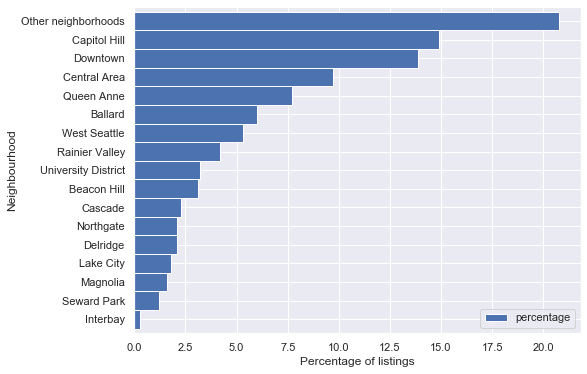

In [8]:
pivot = listings.pivot_table(index=['neighbourhood_group_cleansed'], values=['id'], aggfunc='count', margins=False)
pivot0=pivot.reset_index()
pivot0['percentage']= np.round(100* (pivot0['id']/pivot0['id'].sum()),1)

feq = pivot0[['neighbourhood_group_cleansed', 'percentage']].sort_values('percentage')
feq=feq.set_index('neighbourhood_group_cleansed')
feq.plot.barh(figsize=(8,6),  width= 1)
plt.xlabel('Percentage of listings', fontsize = 12)
plt.ylabel('Neighbourhood', fontsize = 12)
plt.show()

In [9]:
geo_location=listings[["latitude", "longitude"]]

In [10]:
locations = geo_location
map1 = folium.Map(location=[47.62, -122.33], zoom_start=12)
FastMarkerCluster(data=locations, name='Clusters').add_to(map1)
#HeatMap(data=locations, name='HeatMap').add_to(map1)
map1

In [11]:
map1.save('index.html')

#### Tipos de espacios

90.1% de los anuncios corresponden a casas (45.4%) y apartamentos (44.7%), seguidos por 3.1% de casas de campo y 2.4% de Condominios. En los vecindarios de Downtown, CapitolHill, Queen Anee y University District prevalecen los apartamentos sobre las casas, para los demas vecindarios la relación es invertida (más casas que apartamentos en una proporción similar.)

In [12]:
pivot = listings.pivot_table(index=['property_type'], values=['id'], aggfunc='count', margins=False)
pivot1=pivot.reset_index()
pivot1['percentage']= np.round(100* (pivot1['id']/pivot1['id'].sum()),1)
pivot1.sort_values('percentage', ascending=False)

,property_type,id,percentage
9,House,1733,45.4
0,Apartment,1708,44.7
13,Townhouse,118,3.1
7,Condominium,91,2.4
1,Bed & Breakfast,37,1.0
10,Loft,40,1.0
4,Cabin,21,0.6
11,Other,22,0.6
3,Bungalow,13,0.3
5,Camper/RV,13,0.3


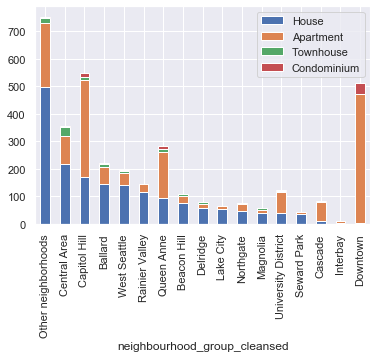

In [13]:
pivot = listings.pivot_table(index=['neighbourhood_group_cleansed'], columns=['property_type'],values=['id'], aggfunc='count', margins=False).fillna(0)
pivot.columns = pivot.columns.droplevel(0) #Remover el indice multilevel en las columnas
pivot = pivot.rename_axis(None, axis=1)
pivot=pivot.sort_values("House", ascending=False)
pivot[["House", "Apartment", "Townhouse", 'Condominium']].plot(kind="bar", stacked=True)
plt.show()

El 66.5% de los espacios listados corresponden a la locación completa bien sean casas o apartamentos, seguidos de 30.4% asociado a habitaciones privadas y solo un 3.1% de habitaciones compartidas 

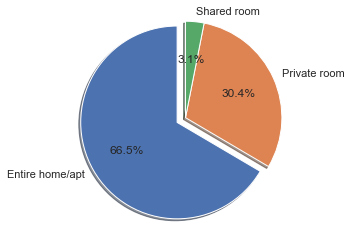

In [14]:
pivot = listings.pivot_table(index=['room_type'], values=['id'], aggfunc='count', margins=False)
pivot1=pivot.reset_index()
pivot1['percentage']= np.round(100* (pivot1['id']/pivot1['id'].sum()),1)
explode = (0.1, 0,0)
fig1, ax1 = plt.subplots()
ax1.pie(pivot1['percentage'], explode=explode, labels=pivot1['room_type'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
listings['price'] = listings['price'].str.replace("[$, ]", "").astype("float")
listings['extra_people'] = listings['extra_people'].str.replace("[$, ]", "").astype("float")


In [16]:
listings['host_response_rate']=listings['host_response_rate'].str.replace("%", "").astype("float")

In [17]:
df=listings[['bedrooms', 'bathrooms', 'beds','number_of_reviews','extra_people','host_response_rate','price', 'room_type']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


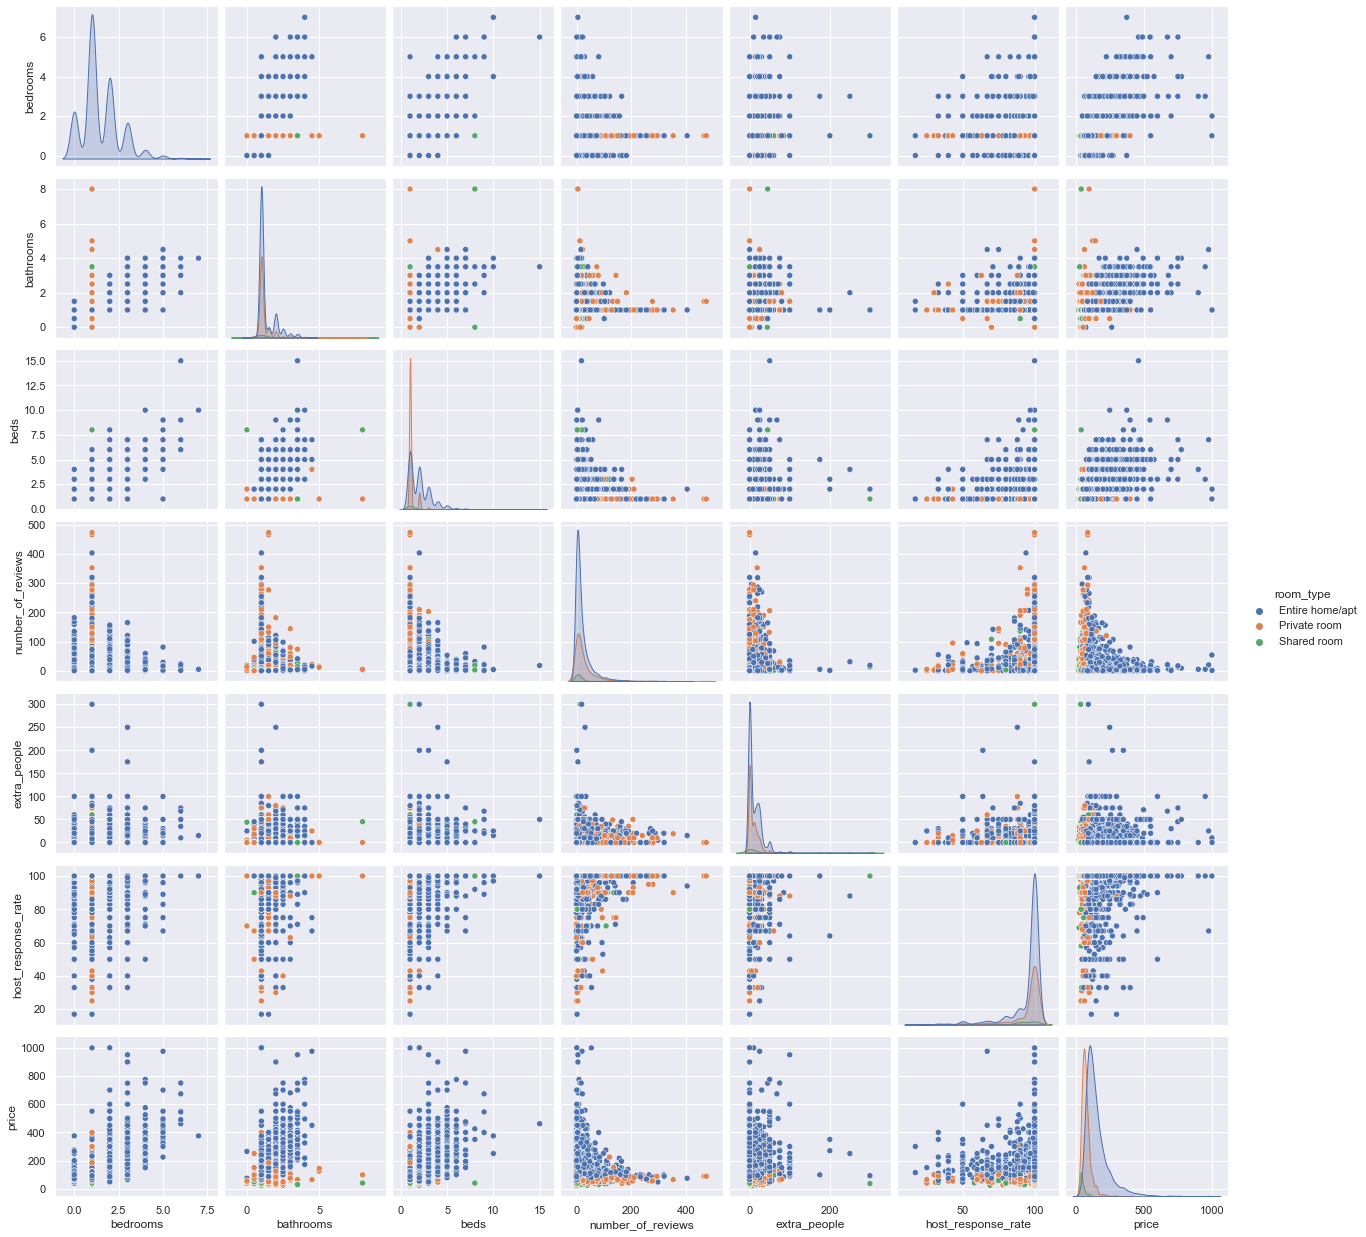

In [18]:
sns.pairplot(df,hue='room_type')
plt.show()

### Pricing

El precio por noche oscila entre 20 y 1.000 dolares. El promedio de precios es similar entre los diferentes tipos de propiedades. Las casas y apartamentos presentan la mayor cantidad de datos atípicos, sobresaliendo las casas por tener una mayor dispersión de precios en relación a los apartamentos. Los botes presentan la mayor diversificación de precios al interior de una misma categoría.

In [19]:
print('Rango de precios:', max(listings['price']), 'y',  min(listings['price']))

Rango de precios: 1000.0 y 20.0


<Figure size 1152x1152 with 0 Axes>

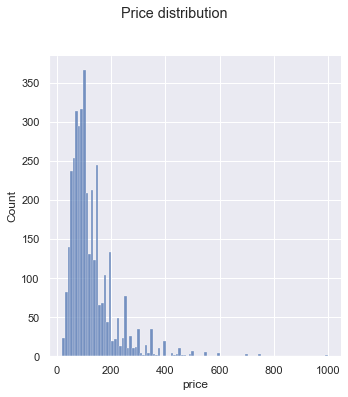

In [20]:
plt.figure(figsize=(16,16))
prices=sns.displot(listings['price'])
prices.fig.suptitle("\n".join(["Price distribution"]), y=1.1)
plt.show()

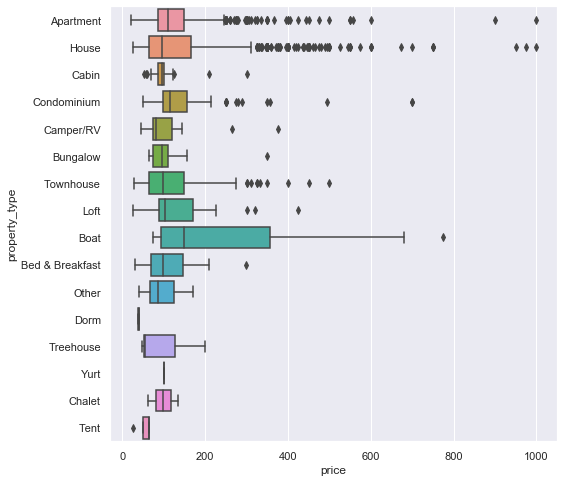

In [21]:
plt.figure(figsize=(8,8))
sns.boxplot(x="price", y="property_type", data=listings)
plt.show()

El tipo de cama en cuartos privados y compartidos, mantiene una distribución similar en cuanto al valor de la renta. Para Entire Home/Apt la Cama Real y el Sofa presentan mayores precios en realción a los otros tipos de cama, adicionalmente el sofa tiene la mayor dispersión en precios.

[]

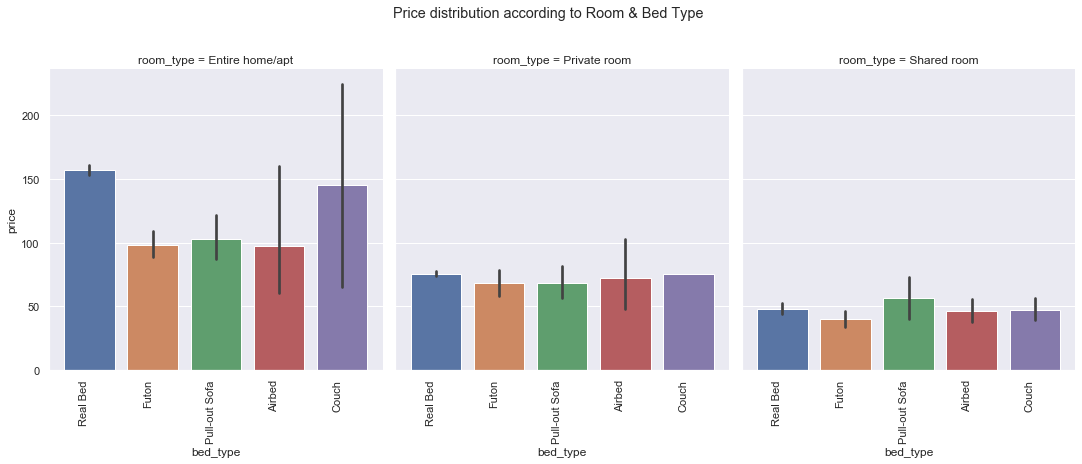

In [22]:
room_bed= sns.catplot(x='bed_type', y='price', col ='room_type', kind= 'bar', data=listings)
room_bed.set_xticklabels(rotation=90, horizontalalignment='right')
room_bed.fig.suptitle("\n".join(["Price distribution according to Room & Bed Type"]), y=1.1)
plt.plot()

### Cuál es el área más costosa?

In [23]:
calendar=pd.read_csv('calendar.csv')

In [24]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Reviews

In [2]:
reviews=pd.read_csv('reviews.csv')

In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


Se utiliza TextBlob para determinar la polaridad promedio de las reviews por espacio, este puntaje oscila entre [-1.0 , 1.0] en donde 1 está asociado con sentimientos positivos y -1 a sentimiento negativo. La importancia de los reviews radica en que solamente usuarios cuya estadia fue efectiva pueden evaluar el espacio dentro de los posteriores 14 días a su alojamiento.

Procesamiento: Remover vacios, retirar lo que no esta en ingles, retirar (æˆ‘ä»¬æ˜¯ä¸€å®¶ä¸‰å£ï¼Œå¯çˆ±çš„å¥³å„¿ï¼Œå¤«å¦»äºŒäººéƒ½æ˜¯ä¸­å›½æ¥çš„è®¿é—®å­¦è€…ï¼Œæ¥åˆ°ç¾Žä¸½çš„è¥¿é›…å›¾ï¼Œä½åœ¨äº†Rogerçš„æˆ¿å­é‡Œï¼Œæˆ¿å­ä½äºŽç¾Žä¸½çš„è‰ºæœ¯å°é•‡fremontï¼Œæœ‰å„ç§å„æ ·çš„é›•å¡‘ï¼Œè¿˜æœ‰å®‡å®™ä¸­å¿ƒçš„è·¯æ ‡ï¼Œå„ç§å°åº—çš„æ©±çª—ä¹Ÿæ˜¯å……æ»¡ç‰¹è‰²ï¼Œå¯Œæœ‰è‰ºæœ¯æ°”æ¯ã€‚å®‰é™ç¾Žä¸½çš„å°é•‡ï¼Œå……æ»¡äº†ç§‹å¤©çš„å‘³é“ã€‚ç¦»è¥¿é›…å›¾å¸‚åŒºæ¯”è¾ƒè¿‘ã€‚æˆ¿å­ä½ç½®å¥½ï¼Œèƒ½ä»Žçª—æˆ·é‡Œçœ‹åˆ°Rainerå±±), 84847

In [4]:
reviews = pd.read_csv('reviews.csv')
reviews = pd.DataFrame.drop(reviews, columns=['id','date','reviewer_id','reviewer_name'])

In [5]:
reviews.shape, len(reviews[reviews['comments'].isna()==True])

((84849, 2), 18)

In [6]:
reviews=reviews.dropna()

In [7]:
def language(entry):
    if (type(entry) != str and math.isnan(entry)):
        return 'To remove'
    Rev_opinion = TextBlob(entry)
    time.sleep(0.1)
    return Rev_opinion.detect_language()

In [10]:
reviews['language'] = reviews['comments'].apply(language)

In [11]:
def polarity(entry):
    if (type(entry) != str and math.isnan(entry)):
        return -2
    Rev_opinion = TextBlob(entry)
    return Rev_opinion.sentiment.polarity, Rev_opinion.detect_language()

reviews['comments'] = reviews['comments'].apply(polarity)

In [ ]:
reviews = reviews[reviews['comments'] != -2]
reviews = reviews.groupby('listing_id')['comments']. mean()
reviews.to_csv('reviews_polarity.csv')

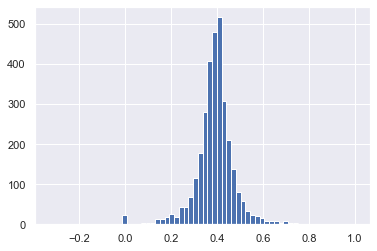

In [68]:
plt.hist(reviews, bins='scott')
plt.show()

In [41]:
reviews = pd.read_csv('reviews.csv')
reviews=reviews['comments']
reviews[1]

'Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.'

In [42]:
testimonial = TextBlob(reviews[1])

In [43]:
testimonial.sentiment

Sentiment(polarity=0.30113636363636365, subjectivity=0.4931818181818182)

The polarity score is a float within the range [-1.0, 1.0], where 1 means positive statement and -1 means a negative statement. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

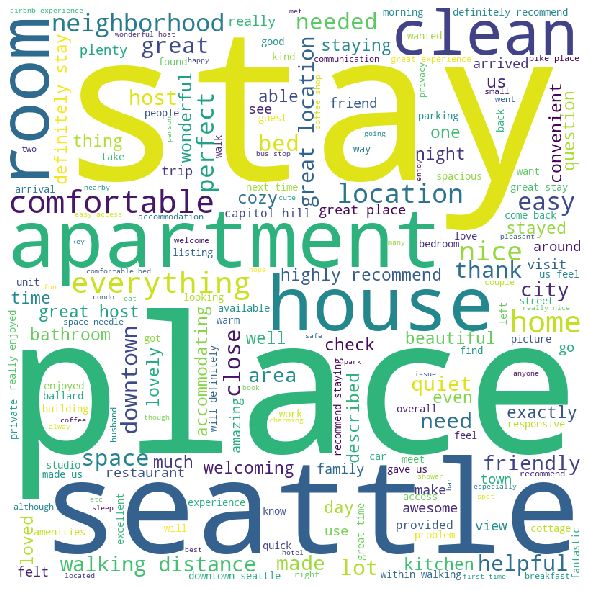

In [56]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
reviews = pd.read_csv('reviews.csv')
df = pd.DataFrame.drop(reviews, columns=['id','date','reviewer_id','reviewer_name'])

  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.comments: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Bibliografía

https://www.geeksforgeeks.org/generating-word-cloud-python/